# Deep neural network architecture development    

This notebook dwells on network architecture search based on convolution layers. 
The goal is to classify thirty dog breed from Stanford dog dataset. 
The notebooks contains : 
-  image **data augmentation** 
-  network architecture hyper-parameters search 
-  hyper-parameters for training tunning with **keras** and **mlflow** 

In [2]:

%load_ext autoreload
%autoreload 2
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import mlflow
# importing shutil module 
import shutil 
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Input, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Input
from common.common_params import data_dir, img_dir, npy_dir, MAX_NUMBER_CLASS, input_shape, image_size, IMG_SIZE, NB_AUGMENTATION
from common.common_plots import display_images, plot_img
from common.common_mlflow import save_experiment_mlflow
from data_load import get_train_val_set, apply_data_augmentation, delete_files_in_directory, copy_files_from_dir, prepare_subfolder_extract
from common.common_plots import plot_train_val_accuracy_and_loss

In [2]:
print(tf.__version__)

2.8.3


## Load dataset 

Let's begin with imbalanced dataset
I choose to use image_dataset_from_directory instead of ImageDataGenerator  because of the speed benchmark [here](https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5)

In [3]:
model_run_config = {
    "experiment_name" : "cnn-dog-breed-classifier",
    "batch_size" : 128,
    "NB_IMG_PER_CLASS" : 200 ,
    "NB_CLASS" : 30 ,
    "num_epochs" : 250 ,
    "input_shape" : input_shape,
    "optimizer" : "adam",
    "metrics" : ['accuracy'],
    "loss" : "categorical_crossentropy",
    "num_augmentations" : 10,
    "data_augmentation" : True
    
}

In [4]:

batch_size              =  model_run_config['batch_size']
NB_IMG_PER_CLASS        =  model_run_config["NB_IMG_PER_CLASS"]
NB_CLASS                =  model_run_config["NB_CLASS"]
num_epochs              =  model_run_config["num_epochs"]
experiment_name         =  model_run_config["experiment_name"]
optimizer               =  model_run_config["optimizer"]
metrics                 =  model_run_config["metrics"]
loss                    =  model_run_config["loss"]
num_augmentations       =  model_run_config["num_augmentations"]
list_of_folder = np.load(os.path.join(npy_dir,"top_breed_folder_list_30.npy"),  allow_pickle=True)

In [5]:
train_dir, test_dir = prepare_subfolder_extract(NB_IMG_PER_CLASS, NB_CLASS, list_of_folder) 

In [6]:
train_ds, validation_ds, class_names = get_train_val_set(train_dir, image_size, batch_size)


Found 6057 files belonging to 30 classes.
Using 4846 files for training.
Found 6057 files belonging to 30 classes.
Using 1211 files for validation.


## Dataset first view 

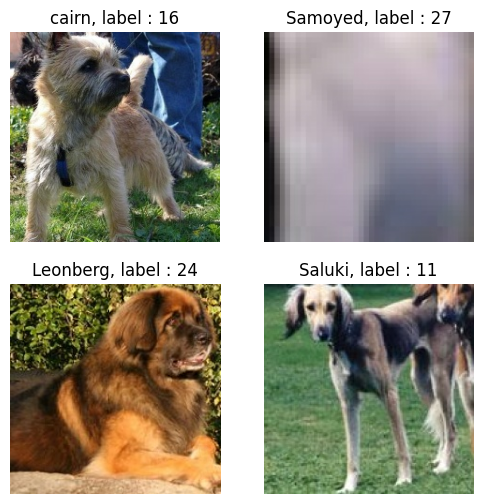

In [14]:

img_list = []
titles = []
for images, labels in train_ds.take(1): # 1 batch
    for i in range(4): 
        img_list.append(images[i].numpy().astype("uint8"))
        idx = np.argmax(labels[i])
        titles.append(f"{class_names[idx].split('-')[1]}, label : {idx}")
display_images(img_list, 2, 2, from_path=False,titles=titles)

<Figure size 1000x1000 with 0 Axes>

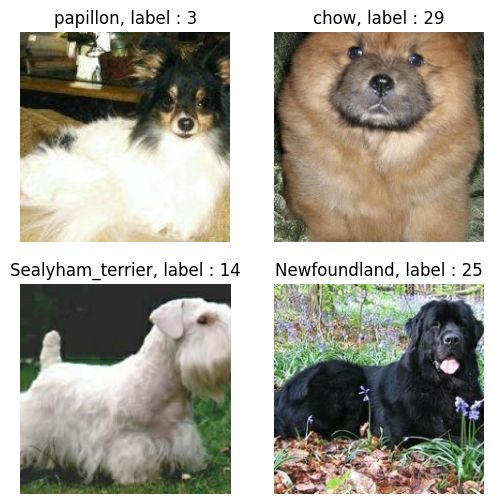

In [15]:
plt.figure(figsize=(10, 10))
img_list = []
titles = []
for images, labels in train_ds.take(1): # 1 batch
    for i in range(4): 
        img_list.append(images[i].numpy().astype("uint8"))
        idx = np.argmax(labels[i])
        titles.append(f"{class_names[idx].split('-')[1]}, label : {idx}")
display_images(img_list, 2, 2, from_path=False,titles=titles)

## Convolution neural network (CNN) hyperparameter tunning 

In [9]:
model_run_config["conv1_width"] =  16
model_run_config["conv2_width"] =  128
model_run_config["conv3_width"] =  256
# model_run_config["conv4_width"] =  256 

model_run_config["conv1_strides"] =  (2,2) 
model_run_config["conv1_kernel"] = (5,5)
model_run_config["conv1_pool_size"] =  (3,3) 
model_run_config["conv2_strides"] =  (2,2) 
model_run_config["conv2_pool_size"] =  (2,2) 
model_run_config["conv3_strides"] =  (2,2) 

model_run_config["dense1_size"] =  64
model_run_config["DropOut"] =  0.6
model_run_config["activation_last_layer"] =  'softmax'

## Data augmentation 

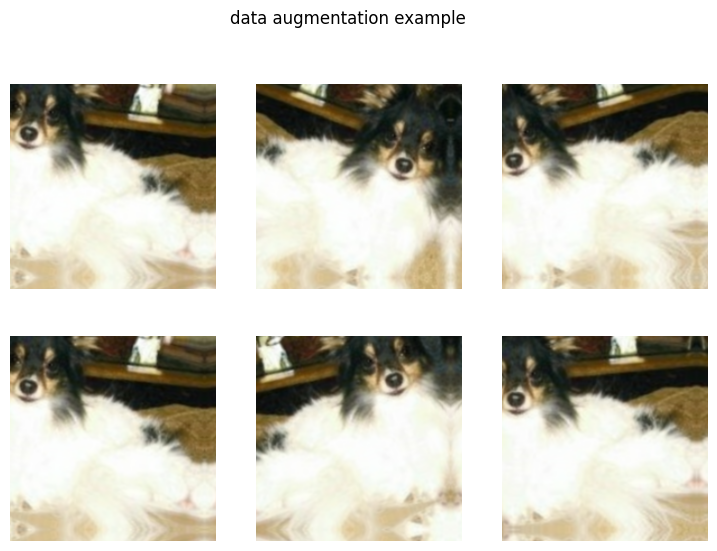

In [18]:
if model_run_config["data_augmentation"] :   
    
    data_augmentation = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
            tf.keras.layers.RandomTranslation(height_factor=(-0.1, -0.1), width_factor=(-0.1, -0.1)),
            tf.keras.layers.RandomContrast(0.01),
            tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.1), width_factor=(-0.1, -0.1)),
        ])

    list_transform = [data_augmentation(tf.expand_dims(img_list[0], axis=0),training=True).numpy().astype("uint8")[0] for _ in range(NB_AUGMENTATION)]

    display_images(list_transform, 2, 3, from_path=False,main_title="data augmentation example")

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Rescaling

def get_personal_model():
    model = Sequential()
    
    model.add(Rescaling( 1.0 / 255 , input_shape=input_shape))
    
    if model_run_config["data_augmentation"] :   
        model.add(data_augmentation)

    model.add(Conv2D(model_run_config["conv1_width"], model_run_config["conv1_kernel"], activation='relu')) # kernel = 3*3
    model.add(MaxPooling2D(model_run_config["conv1_pool_size"], strides=model_run_config["conv1_strides"] ,padding="same"))
    
    model.add(Conv2D(model_run_config["conv2_width"] , (3, 3), activation='relu', strides=model_run_config["conv2_strides"] ))
    model.add(MaxPooling2D(model_run_config["conv2_pool_size"]))
    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))

    # model.add(Conv2D(256, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(model_run_config["conv3_width"] , (3, 3), activation='relu', strides=model_run_config["conv3_strides"] ))
    model.add(MaxPooling2D((2, 2)))
    
    # model.add(Conv2D(model_run_config["conv4_width"] , (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(model_run_config["dense1_size"], activation='relu'))
    
    model.add(Dropout(model_run_config["DropOut"]))
    model.add(Dense(NB_CLASS, activation=model_run_config["activation_last_layer"]))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model 

In [14]:
cnn_based_model = get_personal_model()

In [15]:
cnn_based_model.build(input_shape)

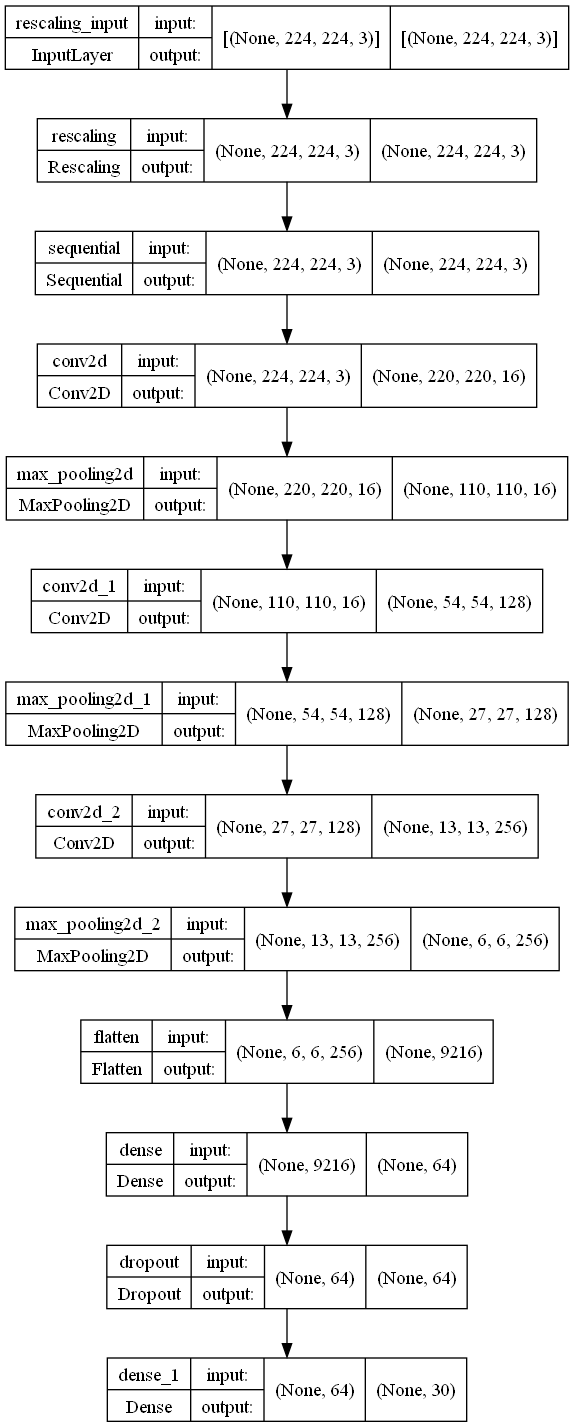

In [16]:
tf.keras.utils.plot_model(cnn_based_model, show_shapes=True)

In [17]:
cnn_based_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 128)       18560     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 27, 128)      0         
 2D)                                                  

In [18]:

run_name = datetime.now().strftime("%Y%m%d_%H%M%S")
logdir = os.path.join(data_dir,"logs", experiment_name, run_name)
tb_callback = [tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)]


In [19]:
os.path.isdir(logdir)

False

## Training 

In [20]:
history = cnn_based_model.fit(
    train_ds,
    epochs=num_epochs,
    callbacks=tb_callback,
    validation_data=validation_ds)

Epoch 1/250
38/38 [==============================] - 70s 2s/step - loss: 3.4033 - accuracy: 0.0409 - val_loss: 3.3986 - val_accuracy: 0.0421
Epoch 2/250
38/38 [==============================] - 68s 2s/step - loss: 3.3672 - accuracy: 0.0530 - val_loss: 3.3670 - val_accuracy: 0.0504
Epoch 3/250
38/38 [==============================] - 73s 2s/step - loss: 3.3579 - accuracy: 0.0481 - val_loss: 3.3580 - val_accuracy: 0.0570
Epoch 4/250
38/38 [==============================] - 89s 2s/step - loss: 3.3326 - accuracy: 0.0578 - val_loss: 3.3266 - val_accuracy: 0.0628
Epoch 5/250
38/38 [==============================] - 89s 2s/step - loss: 3.2983 - accuracy: 0.0681 - val_loss: 3.2684 - val_accuracy: 0.0652
Epoch 6/250
38/38 [==============================] - 90s 2s/step - loss: 3.2825 - accuracy: 0.0700 - val_loss: 3.2757 - val_accuracy: 0.0826
Epoch 7/250
38/38 [==============================] - 90s 2s/step - loss: 3.2509 - accuracy: 0.0737 - val_loss: 3.2650 - val_accuracy: 0.0586
Epoch 8/250
3

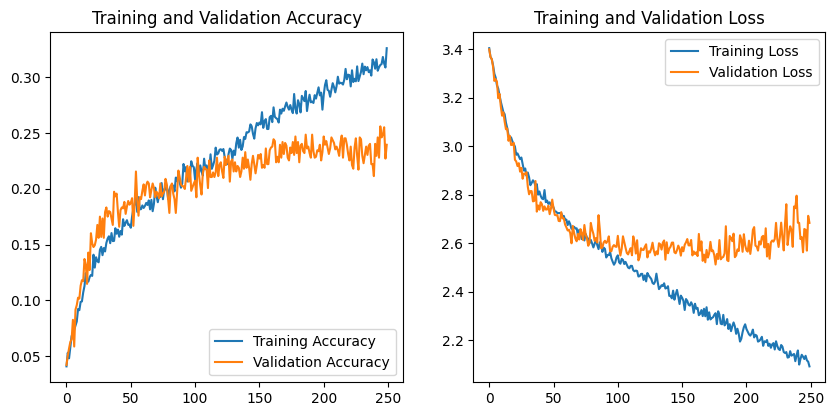

In [21]:
fig = plot_train_val_accuracy_and_loss(history, show=False)

## Log model training parameters

In [22]:
mlflow_run_id = save_experiment_mlflow(cnn_based_model, model_run_config, run_name, history, fig=fig)

MLFlow Run ID:  625e8837200c41afa8fd09b698d6988d
INFO:tensorflow:Assets written to: C:\Users\clara\AppData\Local\Temp\tmpzljdjr0a\model\data\model\assets


## View inference output 

In [23]:
img_path = os.path.join(data_dir,"extracted\\test\\n02085936-Maltese_dog\\n02085936_1244_0.jpg")
img = tf.keras.utils.load_img(
    img_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = cnn_based_model.predict(img_array)[0]
print(predictions)


[2.5095031e-01 1.1706074e-02 3.7730664e-03 2.1426959e-02 3.7297420e-03
 1.8507722e-05 2.8132776e-08 6.9914525e-04 1.5683075e-03 2.0498078e-02
 4.6437268e-05 1.1621630e-02 2.1188681e-08 4.6819510e-05 1.4684737e-01
 1.1007162e-09 2.8005217e-03 1.2883461e-05 3.6938113e-04 1.6524966e-09
 1.7832544e-09 9.2448313e-03 2.6193829e-03 1.3314998e-03 6.4343469e-10
 2.0107936e-11 1.6464740e-01 2.9527405e-01 3.6417767e-02 1.4349754e-02]


In [24]:
class_names_from_folder = [ name.split('-')[1] for name in class_names ]
print(f"This image as a probability {round(100*predictions[0],2)}% {class_names_from_folder[0]} of and a probability { round(100*predictions[1],2)}% of {class_names_from_folder[1]}")

This image as a probability 25.1% Maltese_dog of and a probability 1.17% of Shih
